In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sppla

# Overview

This project is an exploration of ways to solve the 2D heat equation on a given geometry with finite difference methods. We try some classic methods and a multigrid solver.

The problem is interesting because of needing to account for the boundary conditions created by the geometry of the region we're interested in. The boundary conditions are assumed to be either Dirichlet (to model contact with the external environment) or Von-Neumann (to model perfectly insulating walls).

## The 2D region

The 2D domain we investigate is like a room with a kind of fireplace containing a heat source walled in on three sides and another source across it near an opposing wall. There are two openings on two other walls that are set to be in contact with the environment and always remain at a fixed temperature. Running the code below produces a visualization of this geometry.

In [2]:
#Setting the dimensions of the room
sizex = 10.0 #width
sizey = 10.0 #height
wthick = 1 #wall thickness
num_points = 200 #number of intervals we split into (the same in both dimensions)

#functions for the custom room we're building

#defining the domain
def in_domain(x,y):
    return (
    (
        #first excluding walls on all four sides
        (x > wthick) and (x < sizex-wthick)
        and (y > wthick) and (y < sizey-wthick)
    )
    and
        #excluding the insulating faces of the "fireplace"
        not( (x > 0.5*(0.5*sizex-wthick)) and (x < 0.5*(0.5*sizex+wthick)) and (y < sizey*0.6))
    and
        not((x > 0.5*(1.5*sizex-wthick)) and (x < 0.5*(1.5*sizex+wthick)) and (y < sizey*0.6))
        #excluding the windows opening out into the environment
    and not in_window(x,y)
    )

#defining the location of the Dirichlet windows opening into the environment
def in_window(x,y):
    return (
        (
            (x < wthick) and (y > sizey*0.3) and (y < sizey*0.6)
        )
        or
        (
            (x>sizex-wthick) and (y > sizey*0.3) and (y < sizey*0.6)
        )
    )

#defining the location of the heat sources in the room
def in_source(x,y):
    return (
        ((x > 0.5*(sizex-wthick)) and (x < 0.5*(sizex-wthick+1)) and (y > wthick*1.5) and (y < wthick*2.5))
        or
        ((x > 0.5*(sizex-wthick)) and (x < 0.5*(sizex-wthick+1)) and (y > sizey - wthick*2.5) and (y < sizey - wthick*1.5))
    )

In [3]:
#defining an equispaced set of points to iterate over in each dimension
v = np.linspace (0,sizex,num_points)

#defining a grid that represents the 2D domain
to_see = np.ones((num_points,num_points),dtype=int)

#setting points in the grid to be either in the interior, in heat sources, or in windows
for i in range(num_points):
    for j in range(num_points):
        if(in_domain(v[i],v[j])):
            if(in_source(v[i],v[j])):
                to_see[i,j] = 3 #source term
            else:
                to_see[i,j] = 2 #inner term
        else:
            if(in_window(v[i],v[j])):
                to_see[i,j] = 0 #dirichlet

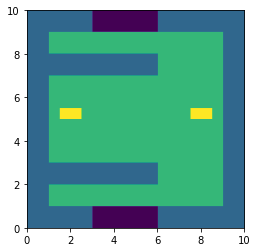

In [4]:
#viewing the room as defined
plt.imshow(to_see, extent=[0,10,0,10])

## The Laplacian

We construct a matrix laplacian for the domain. For points aways from the boundary, because the resolution in both dimensions is the same, we average the four closest points (left and right, above and below) to get a second order central difference approximation.

For Von-Neumann points we use a third order taylor approximation along the normal direction averaging the closest and second closest point in a 4/3: -1/3 ratio.

These difference equations use very few points in the vicinity of a given point for an approximation and the laplacian is thus very sparse. We exploit this by using scipy's support for sparse matrices by storing them as "csr" matrices.

I wrote two versions of the laplacian which turned out to be handy later.

The first version splits the whole laplacian into two parts: one matrix with the central difference terms without boundary conditions, and a "mask" matrix that then reconstructs the values at Von-Neumann points from the interior points. The main reason that I kept this function was that this separation into two steps (and the mask) was useful elsewhere.

The second version of the laplacian function handles both boundary points and the interior in the same matrix and is cleaner.

Both matrices are constructed as sparse matrices where a small number of diagonals are fully specified. The mapping works roughly as follows:

1. There are size^2 points in our domain, and implicitly the laplacian matrix is defined on a size^2 x size^2 matrix (though because of sparsity space usage will be linear and not quadratic in the number of points).
2. The difference equations end up looking like bands when the 2D domain is linearized (in row major with y being the row dimension). Points "size" away are adjacent in the x directions and points 1 away are adjacent in the y direction (edges and corners are handled with more care).
3. The difference equation for each point populates some number of diagonals. Closer analysis shows that 5 diagonals are enough for all the standard central difference terms and 9 diagonals are enough to handle all the Von-Neumann terms.

The end result is that we get an operator that when applied to a linearization of the domain replicates the discrete laplacian on the points. The choice of y being the rows instead of the columns is admittedly unusual but does not affect anything as both dimensions are symmetric, and is just an artefact of the way I named things. I did not feel strongly enough to switch the ys and the xs after getting it to work.

In [5]:
def make_laplacian(see_mat,v_mat,size):
    
    #the 5 diagonals we need for the standard central difference equation
    dmain = np.zeros(size**2, dtype=np.float64) #main diagonal
    
    dxl = np.zeros(size**2 - (size), dtype=np.float64) #for grid points to the left, size places away
    dxr = np.zeros(size**2 - (size), dtype=np.float64) #for grid points to the right
    
    dya = np.zeros(size**2 - 1, dtype=np.float64) #grid points above the given point
    dyb = np.zeros(size**2- 1, dtype=np.float64) #grid points below
    
    #the 9 diagonals we need for the Von Neumann conditions
    emain = np.zeros(size**2, dtype=np.float64) #the main diagonal
    
    exl = np.zeros(size**2 - (size), dtype=np.float64) #points to the left
    exr = np.zeros(size**2 - (size), dtype=np.float64) #to the right
    
    ex2l = np.zeros(size**2 - 2*(size), dtype=np.float64) #two places over to the left - 2
    ex2r = np.zeros(size**2 - 2*(size), dtype=np.float64) #two places over to the right, +2
    
    eya = np.zeros(size**2 - 1, dtype=np.float64) #one places above
    eyb = np.zeros(size**2- 1, dtype=np.float64) #one place below
    
    ey2a = np.zeros(size**2 - 2, dtype=np.float64) #two places above
    ey2b = np.zeros(size**2- 2, dtype=np.float64) #two places below
    
    #initializing the coefficients of these diagonals
    for i in range(size):
        for j in range(size):
            atval = i*size + j #the index i,j is mapped to i + j*size. i-1, i, i+1 horizontal, js vertical
            once = False #to handle corners exactly once (though not a big deal to just be treated on either edge)
            if see_mat[i,j] == 1: #i.e. point is von-neumann, applying the 4/3 : -1/3 weighting
                if i!=0:
                    if see_mat[i-1,j] == 2 or see_mat[i-1,j] ==3: #means you've got values to your left
                        exl[atval-size] = 4.0/3 
                        ex2l[atval-2*size] = -1.0/3
                        once=True
                        
                if i!=size-1 and once==False:
                    if see_mat[i+1,j] == 2 or see_mat[i+1,j] == 3:
                        exr[atval] = 4.0/3
                        ex2r[atval] = -1.0/3
                        once = True
                        
                if j!=0 and once==False:
                    if see_mat[i,j-1] == 2 or see_mat[i,j - 1] == 3 :
                        eya[atval-1] = 4.0/3
                        ey2a[atval-2] = -1.0/3
                        once = True
                        
                if j!=size -1 and once==False:
                    if see_mat[i,j+1] == 2 or see_mat[i,j+1]==3:
                        eyb[atval] = 4.0/3
                        ey2b[atval] = -1.0/3
            else: #point is not von-neumann
                if see_mat[i,j] == 2 or see_mat[i,j] == 3: #standard central difference weighting
                    dmain[atval] = -4.0
                    dxl[atval-size] = 1.0
                    dxr[atval] = 1.0
                    dya[atval -1] = 1.0
                    dyb[atval] = 1.0
                if see_mat[i,j] == 0: #dirichlet points
                    emain[atval] = 0 #zeroing out in the mask, because dirichlets are 0 here
                    dmain[atval] = 1.0 #retaining previous values
                else:
                    emain[atval] = 1.0 #essential
    
    #creating the standard central difference matrix sparsely
    diagonals = [dmain,dxl,dxr,dya,dyb]
    retval = sp.diags(diagonals,[0,-size,size,-1,1],format='csr',dtype=np.float64)
    
    #creating the boundary points correction matrix/mask sparsely
    eiagonals = [emain,exl,exr,ex2l,ex2r,eya,eyb,ey2a,ey2b]
    petval = sp.diags(eiagonals,[0,-size,size,-2*size,2*size,-1,1,-2,2],format='csr',dtype=np.float64)
    return retval, petval #retval is the "standard" laplacian, petval has von-neumann corrections for updates

In [6]:
#this function does not split boundary point handling and interior points into two matrices, just does it in one matrix
def steady_laplacian(see_mat,v_mat,size):
    
    
    #the variables mean essentially the same as the previous function
    #we use the 9 diagonals introduced before for both types of points together
    emain = np.zeros(size**2, dtype=np.float64) #given point
    
    exl = np.zeros(size**2 - (size), dtype=np.float64) #again, to the left, necessary at times
    exr = np.zeros(size**2 - (size), dtype=np.float64) #to the right, necessary at times
    
    ex2l = np.zeros(size**2 - 2*(size), dtype=np.float64) #two places over to the left - 2
    ex2r = np.zeros(size**2 - 2*(size), dtype=np.float64) #two places over to the right, +2
    
    eya = np.zeros(size**2 - 1, dtype=np.float64) #one place above
    eyb = np.zeros(size**2- 1, dtype=np.float64) #one place below
    
    ey2a = np.zeros(size**2 - 2, dtype=np.float64) #two places above
    ey2b = np.zeros(size**2- 2, dtype=np.float64) #two places below
    
    for i in range(size):
        for j in range(size):
            atval = i*size + j #the index i,j is mapped to i + j*size. i-1, i, i+1 horizontal, js vertical
            once = False #to handle corners exactly once, shouldn't be a big deal either way
            if see_mat[i,j] == 1: #point is von-neumann, needs to be given a value
                if i!=0:
                    if see_mat[i-1,j] == 2 or see_mat[i-1,j] ==3: #means you've got values to your left
                        exl[atval-size] = 4.0/3 
                        ex2l[atval-2*size] = -1.0/3
                        once=True
                        
                if i!=size-1 and once==False:
                    if see_mat[i+1,j] == 2 or see_mat[i+1,j] == 3:
                        exr[atval] = 4.0/3
                        ex2r[atval] = -1.0/3
                        once = True
                        
                if j!=0 and once==False:
                    if see_mat[i,j-1] == 2 or see_mat[i,j - 1] == 3 :
                        eya[atval-1] = 4.0/3
                        ey2a[atval-2] = -1.0/3
                        once = True
                        
                if j!=size -1 and once==False:
                    if see_mat[i,j+1] == 2 or see_mat[i,j+1]==3:
                        eyb[atval] = 4.0/3
                        ey2b[atval] = -1.0/3
                        once=True
                emain[atval] = -1.0 #constraining the von_neumann point
            else:
                if see_mat[i,j] == 2 or see_mat[i,j] == 3:
                    emain[atval] = -4.0
                    exl[atval-size] = 1.0
                    exr[atval] = 1.0
                    eya[atval -1] = 1.0
                    eyb[atval] = 1.0
                if see_mat[i,j] == 0:
                    emain[atval] = 1.0 #making dirichlet 1, fixed to value in source

    eiagonals = [emain,exl,exr,ex2l,ex2r,eya,eyb,ey2a,ey2b]
    petval = sp.diags(eiagonals,[0,-size,size,-2*size,2*size,-1,1,-2,2],format='csr',dtype=np.float64)
    return petval #only one matrix that correctly handles all mappings

## Helper functions and Classic solvers

In this section I define a few helper functions and one explicit and implicit solver.

We first define a direct solver that directly computes the system's steady state (i.e. when temperatures do not change) by just solving the matrix equation defined by the laplacian on the start state. This is useful if we want to know what the system will end up looking like, and runs very quickly as operations are on sparse matrices.

The make_source function returns a linearization of the domain where the source points are assigned a heat value of 0.5. (The outside environment is 0 and everything except the sources start at 0)

The explicit method I chose to test is the [standard FTCS scheme](https://en.wikipedia.org/wiki/FTCS_scheme#:~:text=In%20numerical%20analysis%2C%20the%20FTCS,applied%20to%20the%20heat%20equation.). One has to be careful about choosing the right time step for solutions to be stable. The timestep used here is the standard one obtained by fourier-analytic methods.

The implicit method I chose is [crank-nicolson](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method). This is stable for most reasonable choices of timestep (O(spacing^2) here), but unfortunately rather slow when applied to the problem at hand.

In [7]:
#function that directly solves for the stationary state by setting laplacian * steady_state = - source_terms
def direct_solve(see_mat,v_mat,size,source):
    h = v_mat[2] - v_mat[1]
    lap = steady_laplacian(see_mat,v_mat,size)
    u = sppla.spsolve(-lap,source*(h**2))
    return u

In [8]:
#marks points in the source as having a temperature of 0.5 - completely arbitrary
def make_source(see_mat,size):
    retval = np.zeros(size**2,dtype=np.float64)
    for i in range(size):
        for j in range(size):
            if see_mat[i,j] == 3:
                retval[i*size + j] = 0.5
    return retval

In [9]:
#Steady solver that uses the steady laplacian
#lap = laplacian, r = source
def FTCS_steady_solve(lap, v_mat, size, start, r, time):
    dt = 0.25*(v_mat[2] - v_mat[1])**2 #acceptable timestep for stability
    T = 0
    u = np.copy(start)
    while T < time:
        u = u + 0.25*(lap.dot(u)) + r*dt
        T = T + dt
    return u

In [10]:
# a standard second order runge-kutta method used for tests
def RK2_solve(see_mat,v_mat,size,start,r,time):
    dt = 0.25*(v_mat[2] - v_mat[1])**3
    lap, neu_cor = make_laplacian(see_mat, v_mat, size)
    lap = steady_laplacian(see_mat,v_mat,size)
    h = v_mat[2] - v_mat[1]
    lam = dt/h**2
    T = 0
    u = np.copy(start)
    while T < time:
        k1 = lam*(lap.dot(u)) + r*dt
        v = u+0.5*k1 #neu_cor.dot(u+0.5*k1) #neumann_correction
        k2 = lam*(lap.dot(v)) + r*dt
        u = u + k2
        #u = neu_cor.dot(u) #neumann_correction, also forces grid points to zero
        T = T + dt
    return u

In [11]:
#standard Crank-Nicolson

def crank_out(lap,neu_corr,v_mat,source,start,size,time):
    u = np.copy(start)
    h = v_mat[2] - v_mat[1]
    dt = h**2
    lam = dt/(2*h**2)
    T = 0
    I = sp.diags([1],[0],shape=(size**2,size**2))
    while T < time:
        u = (I + lam*lap).dot(u) + source*dt
        u = sppla.spsolve(I - lam*lap, u)
        u = neu_corr.dot(u)
        T += dt
    return u

## Comparing classic methods

### Directly solving for the stationary state

Here we just solve the steady state equation at infinite time directly from the laplacian. This runs rather quickly (in < 5s on most machines). 

0.7745094512050223


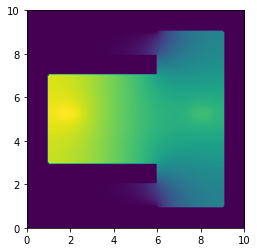

In [12]:
v = np.linspace (0,sizex,num_points)
r = make_source(to_see, num_points)
steady_res = direct_solve(to_see,v,num_points,r)
plt.imshow(steady_res.reshape(num_points,-1), extent=[0,10,0,10])
print(np.max(steady_res)) #useful to check for overflow

### The FTCS solver

I use the FTCS solver to estimate what the state looks like at T = 300 units (a reasonably "long" time, close to the stationary state). This takes around 2 - 3 minutes on most machines but just comparing the hottest values with the steady state should reassure us that convergence is happening. (Alternatively one can skip this and go straight on to the multigrid solver, as Crank-Nicolson takes even longer...)

0.7736820743416328


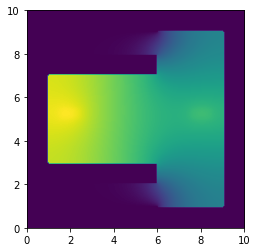

In [13]:
source = make_source(to_see,num_points)
#plt.imshow(lap.toarray().reshape(num_points,-1))
start = np.zeros(num_points**2,dtype=np.float64)
#final = FTCS_solve(to_see,v,num_points,start,source,300) #uncomment this and comment next line to compare speeds
lap = steady_laplacian(to_see,v,num_points)
final = FTCS_steady_solve(lap,v,num_points,start,source,300)
plt.imshow(final.reshape(num_points,-1), extent=[0,10,0,10])
print(np.max(final)) #useful to check for overflow

### Crank Nicolson

This takes about 3 minutes to run to T = 4 units, so running close to steady state will take quite a while. However it's interesting to see what the solution looks like close to the start. (Alternatively this can be skipped)

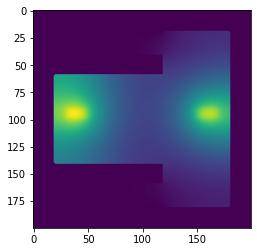

In [14]:
time = 4 #can be changed to be longer, execution time scales linearly
v = np.linspace (0,sizex,num_points)
r = make_source(to_see, num_points)
start = np.zeros(num_points**2,dtype=np.float64)
lap, neu_corr = make_laplacian(to_see,v,num_points)
res = crank_out(lap, neu_corr,v,r,start,num_points,time)
plt.imshow(res.reshape(num_points,-1))

### Geometric Multigrid

In this section we implement a V-cycle multigrid method. The basic idea is described in several places, like [here](https://www.comsol.com/blogs/on-solvers-v-cycle-multigrid/).

We implement a geometric multigrid with three grids, each with half the points in each dimension (spaced out uniformly). Then we define prolongation and restriction operators (which is the tedious part), with sparse matrices much like the laplacian from before, and we can finally write a relatively elegant v_cycle function that we can run on random noise until the residual falls to a sufficiently low threshold.

In [15]:
#a random noise function that fills the interior of the grid with random noise, visualized later
def make_guesses(see_mat, size):
    u = np.random.rand(size**2)
    for i in range(size):
        for j in range(size):
            if see_mat[i,j] != 2 and see_mat[i,j]!=3:
                u[i*size + j] = 0
    return u

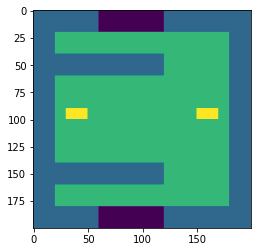

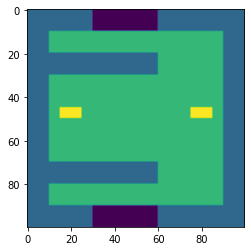

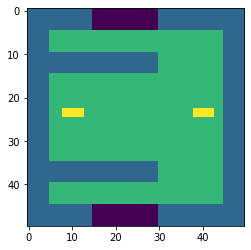

In [16]:
#defining the three grids of the multigrid

level_0 = to_see #the base grid that we've been working with all this time

level_1 = np.copy(to_see[::2,::2]) #the first level grid, with half the points in both dimensions as level_0

level_2 = np.copy(level_1[::2,::2]) #the second level grid, with half the points in both dimensions as level_1

#viewing what this looks like 
#the axes should be taken to mean that there are half the number of points at each level, but dimensions are the same
plt.imshow(level_0)
plt.figure()
plt.imshow(level_1)
plt.figure()
plt.imshow(level_2)

### The Prolongation Operator

I chose a relatively simple/standardly described prolongation operator. On grids of twice the size, it copies over points that exactly overlap, while interpolating unknown values either as the average of two neighbors (if on a row that is carried over into the prolongation) or as the average of its four closest neighbors (in both dimensions, if on a row that is newly created in the prolongation). Then this operator is applied directly to the levels in question and stored for use in the v_cycle. Boundary points are conveniently handled using the mask operator from the laplacian written earlier.

In [17]:
#linear interpolation is second order accurate, and we're basically linearly interpolating while prolonging
#the boundary conditions are handled last, after all other values are put in. I had already written a laplacian that
#knows how to construct boundary points from non-boundary points. Will just directly use this!


def make_prolongation(level,size):
    data = []
    row_inds = []
    col_inds = []
    for i in range(size):
        for j in range(size):
            if level[i,j] == 2 or level[i,j] == 3: #in business, not a boundary point in the target
                row = i*size + j
                if i %2 == 0:
                    if j %2 ==0:
                        #this is the case of exactly overlapping
                        col = int(i/2)*int(size/2) + int(j/2)
                        data.append(1.0)
                        row_inds.append(row)
                        col_inds.append(col)
                        
                        #when the point is sandwiched between two overlapping neighbors in the same row
                    if j%2 == 1:
                        col = int(i/2)*int(size/2) + int(j/2)
                        
                        data.append(0.5)
                        row_inds.append(row)
                        col_inds.append(col)
                        
                        data.append(0.5)
                        row_inds.append(row)
                        col_inds.append(col+1) #the point to the right in the coarser grid
                else:
                    #when the point is sandwiched between two overlapping neighbors in the same column
                    if j%2 == 0:
                        col = int(i/2)*int(size/2) + int(j/2)
                        data.append(0.5)
                        row_inds.append(row)
                        col_inds.append(col)
                        
                        data.append(0.5)
                        row_inds.append(row)
                        col_inds.append(col+int(size/2)) #the point below
                    else:
                        #when all four closest neighbors are not overlapping points, average them all
                        col = int(i/2)*int(size/2) + int(j/2)
                        data.append(0.25)
                        row_inds.append(row)
                        col_inds.append(col)
                        
                        
                        data.append(0.25)
                        row_inds.append(row)
                        col_inds.append(col+1)
                        
                        data.append(0.25)
                        row_inds.append(row)
                        col_inds.append(col+int(size/2))
                        
                        data.append(0.25)
                        row_inds.append(row)
                        col_inds.append(col+int(size/2)+1) #the point below and to the right
    #creating a sparse matrix out of these
    p = sp.csr_matrix((data,(row_inds,col_inds)),shape=(size**2,(int(size/2))**2))
    #storing the von_neumann correction matrix/mask for use later
    dummy,p_corr = make_laplacian(level,np.linspace (0,sizex,size),size)
    return p, p_corr #returning both

In [18]:
p2, p2_corr = make_prolongation(level_1, 100)
p1, p1_corr = make_prolongation(level_0, 200)

### The Restriction operator

I used a simple restriction operator that just takes a weighted average of the point and all 8 closest points around it in the longer grid. The single exactly overlapping point is given a weight of 0.25, the next four closest points (in both directions) are given weights of 0.125 each, and the next four closest ones (diagonally apart on the larger grid's squares) are weighted 0.0625 apiece. This is enough to be second order accurate.

In [19]:
def make_restriction(level,size):
    data = []
    row_inds = []
    col_inds = []
    for i in range(size):
        for j in range(size):
            if level[i,j] == 2 or level[i,j] == 3: #in business, not a boundary point in the target
                row = i*size + j
                col = (2*i)*(2*size) + 2*j
                
                data.append(0.25)
                row_inds.append(row)
                col_inds.append(col)
                        
                #immediate l/r/u/p successors
                data.append(0.125)
                row_inds.append(row)
                col_inds.append(col+1)
                
                data.append(0.125)
                row_inds.append(row)
                col_inds.append(col-1)
                
                data.append(0.125)
                row_inds.append(row)
                col_inds.append(col+2*size)
                
                data.append(0.125)
                row_inds.append(row)
                col_inds.append(col-2*size)
                        
                #2-over successors
                data.append(0.0625)
                row_inds.append(row)
                col_inds.append(col+1-2*size)
                
                data.append(0.0625)
                row_inds.append(row)
                col_inds.append(col-1+2*size)
                
                data.append(0.0625)
                row_inds.append(row)
                col_inds.append(col+2*size+1)
                
                data.append(0.0625)
                row_inds.append(row)
                col_inds.append(col-2*size-1)
                        
                        
    restr = sp.csr_matrix((data,(row_inds,col_inds)),shape=(size**2,(2*size)**2))
    dummy,restr_corr = make_laplacian(level,np.linspace (0,sizex,size),size)
    return restr, restr_corr

In [20]:
r1, r1_corr = make_restriction(level_2,50)
r0, r0_corr = make_restriction(level_1,100)

### The V-Cycle

Finally we implement the smoothening function and the V-Cycle. 

The smoothening function is just [weighted jacobi iteration](https://en.wikipedia.org/wiki/Jacobi_method#Weighted_Jacobi_method).

The V-Cycle is written in the standard recursive way:
Base case: At the lowest level, we directly solve, because at this courseness the computation is not very expensive.
Recursive case:
1. First smoothen a few times with weighted jacobi (here 10 and 3 times at levels 0 and 1 respectively)
2. Compute the residual, which is the difference between source terms and the laplacian applied to the state vector (which should go to zero)
3. Restrict this residual with a restriction operator and feed it to a lower level as a source term to solve for. We get a correction vector back, which we prolong with our prolongation operator and add back to our current answer.
4. Finally smoothen a few times before returning.

In [21]:
#making the laplacians for each level
A0 = steady_laplacian(level_0,np.linspace(0,sizex,200),200)
A1 = steady_laplacian(level_1,np.linspace(0,sizex,100),100)
A2 = steady_laplacian(level_2,np.linspace(0,sizex,50),50)

In [22]:
#standard weighted jacobi iteration, with a weight of 0.05
def smoothen(A, w, f, size, iters):
    lap= -1.0*A
    D = sp.diags([lap.diagonal()],[0],shape=(size**2,size**2))
    R = lap - D
    u = np.copy(w)
    its = 0
    alph = 0.05
    while its < iters:
        up1 = f - (R.dot(u))
        up1 = sppla.spsolve(D,up1)
        u = (1-alph)*up1 + alph*u
        its += 1
    return u

In [23]:
def v_cycle(level,w, f):
    if level == 2:
        return sppla.spsolve(-A2,f) #directly solving
    
    elif level == 1:
        v = smoothen(A1, w, f, 100, 10)
        residual = f + A1.dot(v) 
        rest_residual = r1_corr.dot(r1.dot(residual))
        guess = np.zeros(rest_residual.shape) #does not matter as the next level is the lowest level
        corr = p2_corr.dot(p2.dot(v_cycle(2,guess,rest_residual)))
        
        v = v + corr
        
        v = smoothen(A1,v,f,100,10)
        
        return v
    else:
        v = smoothen(A0, w, f, 200, 3)
        residual = f + A0.dot(v) 
        rest_residual = r0_corr.dot(r0.dot(residual))
        f_res = r0_corr.dot(r0.dot(f))
        guess = np.zeros(rest_residual.shape)
        
        corr = p1_corr.dot(p1.dot(v_cycle(1,guess,rest_residual)))
        
        v = v + corr
        v = smoothen(A0,v,f,200,3)
        return v

### Running the V-Cycle

Starting with random noise, we run the V-Cycle some number of times. Here I chose to run for about 150 iterations, which takes about 45 seconds. The residual gets to around 1e-6 or 1e-7.

[3.714431037421022]
Running for 150 iterations...


/usr/local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Finished with a residual of: 1.0676846123325312e-06


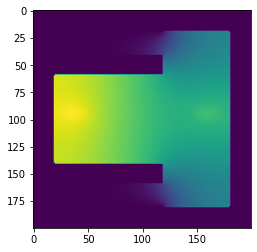

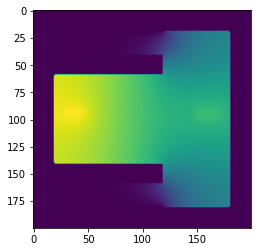

In [24]:
w = make_guesses(level_0,200)
source = make_source(level_0, 200)*0.0025
reses = [la.norm(source + A0.dot(w),np.inf)]
print(reses)
num_iters = 150 #increase for higher convergence
print("Running for "+ str(num_iters) + " iterations...")
for i in range(num_iters):
    w = v_cycle(0,w,source)
    res_val = la.norm(source + A0.dot(w),np.inf)
    reses.append(res_val)
print("Finished with a residual of: " + str(res_val))
plt.imshow(w.reshape(200,-1))
plt.figure()
plt.imshow(sppla.spsolve(-A0,source).reshape(200,-1))

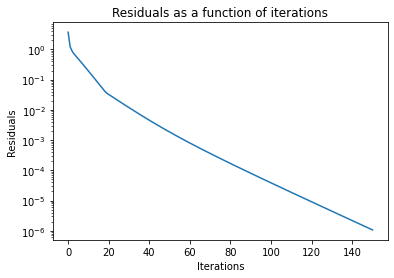

In [25]:
#creates a graph of residuals vs iterations
iterations = [i for i in range(len(reses))]
plt.semilogy(iterations,reses)
plt.ylabel("Residuals")
plt.xlabel("Iterations")
plt.title("Residuals as a function of iterations")
plt.show()